# **Melanoma Detection Using Deep Learning**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Carregar bibliotecas
import os
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, BatchNormalization, Dropout, Flatten, Dense, GlobalAveragePooling2D, Input, Lambda
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom, RandomTranslation
from tensorflow.keras.preprocessing.image import img_to_array, load_img, save_img
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Loss, CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.utils import register_keras_serializable
from tensorflow.keras.applications import MobileNetV2, InceptionV3, VGG16
from tensorflow.keras.applications.mobilenet import preprocess_input
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import shutil

%config InlineBackend.figure_format = 'svg'

# **1. Segmentação**

In [ ]:
# Definir callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=30,
    verbose=1,
    restore_best_weights=True
)

save_best = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/drive/MyDrive/MS Data Science/Deep Learning for Computer Vision/TrabalhoAPVC/data/tmp/best_seg.keras',
    monitor='val_loss',
    save_best_only=True
)

# Definir loss function customizada
@register_keras_serializable('JaccardDistanceLoss')
class JaccardDistanceLoss(Loss):
    def __init__(self, reduction='auto', name=None):
        super().__init__(reduction=reduction, name=name)

    def call(self, y_true, y_pred, smooth =100):
      intersection = tf.reduce_sum(y_true * y_pred, axis=(1,2))
      sum_ = tf.reduce_sum(y_true + y_pred, axis=(1,2))
      jac = (intersection + smooth) / (sum_ - intersection + smooth)
      jd =  (1 - jac) * smooth
      return tf.reduce_mean(jd)

# Definir arquitetura do modelo de segmentação
def create_seg_model(input_shape):
    inputs = Input(shape=input_shape)

    # Camadas de Convolução
    x = Conv2D(8, (5, 5), activation='relu', padding='same')(inputs) # c-1
    x = BatchNormalization()(x)

    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x) # c-2
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)  # p-1

    x = Conv2D(32, (4, 4), activation='relu', padding='same')(x) # c-3
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)  # p-2

    x = Conv2D(64, (4, 4), activation='relu', padding='same')(x) # c-4
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)  # p-3

    x = Dropout(0.5)(x)

    x = Conv2D(64, (5, 5), activation='relu', padding='same')(x) # c-5
    x = BatchNormalization()(x)

    # Camadas de Deconvolução
    x = Conv2DTranspose(64, (5, 5), activation='relu', padding='same')(x) # d-1
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)  # u-1

    x = Conv2DTranspose(32, (4, 4), activation='relu', padding='same')(x) # d-2
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)  # u-2

    x = Conv2DTranspose(16, (4, 4), activation='relu', padding='same')(x) # d-3
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)  # u-3

    x = Dropout(0.5)(x)

    x = Conv2DTranspose(8, (3, 3), activation='relu', padding='same')(x) # d-4
    x = BatchNormalization()(x)

    outputs = Conv2DTranspose(1, (5, 5), activation='sigmoid', padding='same')(x)

    model = Model(inputs, outputs)
    return model

# Carregar datasets
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [192, 256])
    image = image / 255.0
    return image

def load_mask(mask_path):
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, [192, 256])
    mask = mask / 255.0
    mask = tf.round(mask)  # Ensure binary mask
    return mask

def load_data(image_dir, mask_dir, batch_size):
    image_files = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir)])
    mask_files = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir)])

    dataset = tf.data.Dataset.from_tensor_slices((image_files, mask_files))
    dataset = dataset.map(lambda x, y: (load_image(x), load_mask(y)), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

train_data = load_data('/content/drive/MyDrive/MS Data Science/Deep Learning for Computer Vision/TrabalhoAPVC/data/pre_segmentation/train_images',
                       '/content/drive/MyDrive/MS Data Science/Deep Learning for Computer Vision/TrabalhoAPVC/data/pre_segmentation/train_masks', 16)
val_data = load_data('/content/drive/MyDrive/MS Data Science/Deep Learning for Computer Vision/TrabalhoAPVC/data/pre_segmentation/val_images',
                     '/content/drive/MyDrive/MS Data Science/Deep Learning for Computer Vision/TrabalhoAPVC/data/pre_segmentation/val_masks', 16)
test_data = load_data('/content/drive/MyDrive/MS Data Science/Deep Learning for Computer Vision/TrabalhoAPVC/data/pre_segmentation/test_images',
                      '/content/drive/MyDrive/MS Data Science/Deep Learning for Computer Vision/TrabalhoAPVC/data/pre_segmentation/test_masks',16)

# Camada de data augmentation
data_augmentation = tf.keras.Sequential([
    RandomFlip('horizontal'),
    RandomFlip('vertical'),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomTranslation(0.1, 0.1)
])

def augment_data(image, mask):
    return data_augmentation(image), mask

train_aug_data = train_data.map(augment_data)

In [ ]:
# Criar o modelo
input_shape = (192, 256, 3)
model = create_seg_model(input_shape)
model.compile(optimizer=Adam(learning_rate=0.01), loss=JaccardDistanceLoss(), metrics=['accuracy'])

# Output sumario do modelo
model.summary()

# Treinar o modelo
history = model.fit(train_aug_data, validation_data=val_data, epochs=100, callbacks=[early_stopping, save_best])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_38 (InputLayer)       [(None, 192, 256, 3)]     0         
                                                                 
 conv2d_85 (Conv2D)          (None, 192, 256, 8)       608       
                                                                 
 batch_normalization_89 (Ba  (None, 192, 256, 8)       32        
 tchNormalization)                                               
                                                                 
 conv2d_86 (Conv2D)          (None, 192, 256, 16)      1168      
                                                                 
 batch_normalization_90 (Ba  (None, 192, 256, 16)      64        
 tchNormalization)                                               
                                                                 
 max_pooling2d_35 (MaxPooli  (None, 96, 128, 16)       0   

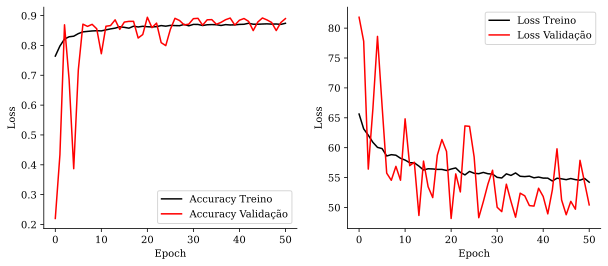

In [ ]:
# Apresentar evolução da loss e da accuracy ao longo do treino
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

plt.figure(2, figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.plot(history['accuracy'], label='Accuracy Treino', color='black')
plt.plot(history['val_accuracy'], label='Accuracy Validação', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.plot(history['loss'], label='Loss Treino', color='black')
plt.plot(history['val_loss'], label='Loss Validação', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [ ]:
# Carregar o melhor modelo
model = tf.keras.models.load_model('/content/drive/MyDrive/MS Data Science/Deep Learning for Computer Vision/TrabalhoAPVC/data/tmp/best_cdnn.keras', custom_objects={'JaccardDistanceLoss': JaccardDistanceLoss})

# Avaliar o modelo
test_images = []
test_masks = []
predicted_masks = []

for image, mask in test_data:
    test_images.append(image)
    test_masks.append(mask)
    predicted_masks.append(model.predict(image, verbose = 0))

test_images = tf.concat(test_images, axis=0)
test_masks = tf.concat(test_masks, axis=0)
predicted_masks = tf.concat(predicted_masks, axis=0)

def calculate_metrics(y_true, y_pred):
    y_pred = tf.cast(y_pred, tf.float32)
    y_true = tf.cast(y_true, tf.float32)

    y_pred = tf.where(y_pred > 0.5, 1.0, 0.0)

    y_true = tf.keras.backend.flatten(y_true)
    y_pred = tf.keras.backend.flatten(y_pred)

    TP = tf.reduce_sum(y_true * y_pred)
    TN = tf.reduce_sum((1 - y_true) * (1 - y_pred))
    FP = tf.reduce_sum((1 - y_true) * y_pred)
    FN = tf.reduce_sum(y_true * (1 - y_pred))

    AC = (TP + TN) / (TP + FP + TN + FN)
    SE = TP / (TP + FN)
    SP = TN / (TN + FP)
    DI = 2 * TP / (2 * TP + FN + FP)
    JA = TP / (TP + FN + FP)

    return {
        'accuracy': AC.numpy(),
        'sensitivity': SE.numpy(),
        'specificity': SP.numpy(),
        'dice_coefficient': DI.numpy(),
        'jaccard_index': JA.numpy()
    }

y_true = tf.convert_to_tensor(test_masks, dtype=tf.float32)
y_pred = model.predict(test_images, verbose = 0)
y_pred = tf.convert_to_tensor(y_pred, dtype=tf.float32)

metrics = calculate_metrics(y_true, y_pred)
print(metrics)

{'accuracy': 0.886288, 'sensitivity': 0.6607999, 'specificity': 0.95597094, 'dice_coefficient': 0.73288906, 'jaccard_index': 0.57839376}


# **2. Processamento**


In [ ]:
# Carregar o melhor modelo de segmentação
model = tf.keras.models.load_model(
    '/content/drive/MyDrive/MS Data Science/Deep Learning for Computer Vision/TrabalhoAPVC/data/tmp/best_cdnn.keras',
    custom_objects={'JaccardDistanceLoss': JaccardDistanceLoss}
)

# Carregar o ficheiro CSV com as labels
csv_path = '/content/drive/MyDrive/MS Data Science/Deep Learning for Computer Vision/TrabalhoAPVC/data/labels.csv'
df = pd.read_csv(csv_path)

# Criar um dicionário com os labels
label_dict = df.set_index('image_id').T.to_dict('list')

# Definir função de segmentação
def dual_threshold_segmentation(image_path, model, label_dict, output_base_dir='/content/drive/MyDrive/MS Data Science/Deep Learning for Computer Vision/TrabalhoAPVC/data/segmentation_outputs', thH=0.8, thL=0.5):
    image_id = os.path.splitext(os.path.basename(image_path))[0]
    if image_id not in label_dict:
        print(f"Image ID {image_id} not found in the CSV file.")
        return

    labels = label_dict[image_id]

    if labels[0] == 1.0:
        output_dir = os.path.join(output_base_dir, 'Mel')
    elif labels[1] == 1.0:
        output_dir = os.path.join(output_base_dir, 'QS')
    else:
        output_dir = os.path.join(output_base_dir, 'Nev')

    # Criar diretório de output se não existir
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [192, 256])
    image = image / 255.0

    # Expandir dimensão para batch size 1
    image_expanded = tf.expand_dims(image, axis=0)

    # Prever a segmentação da imagem com o melhor modelo
    segmentation_map = model.predict(image_expanded)[0]

    # Verificar se a imagem é 3D e remover a última dimensão
    if segmentation_map.ndim == 3:
        segmentation_map = segmentation_map.squeeze(axis=-1)

    # Aplicar primeiro thresholding à segmentação
    high_threshold_mask = segmentation_map > thH
    high_threshold_mask = high_threshold_mask.astype(np.uint8)

    # Encontrar componentes conexos na máscara binária
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(high_threshold_mask, connectivity=8)
    if num_labels <= 1:
        print(f"No components found in {image_id} with high threshold. Saving original image.")
        image_np = (image.numpy() * 255).astype(np.uint8)
        image_np = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)

        # Guardar a imagem original
        final_image_path = os.path.join(output_dir, f"{image_id}.png")
        cv2.imwrite(final_image_path, image_np)
        print(f'Saved: {final_image_path}')
        return

    largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])

    # Aplicar segundo thresholding à segmentação
    low_threshold_mask = segmentation_map > thL
    low_threshold_mask = low_threshold_mask.astype(np.uint8)

    # Dilatar a máscara binária com um kernel 3x3
    kernel = np.ones((3, 3), np.uint8)
    low_threshold_mask_dilated = cv2.dilate(low_threshold_mask, kernel, iterations=1)

    # Determinar uma máscara final com base na maior componente conexa
    final_mask = np.zeros_like(low_threshold_mask_dilated)
    final_mask[labels == largest_label] = 1

    # Converter a imagem para numpy
    image_np = image.numpy()

    # Aplicar a máscara final à imagem
    final_mask = tf.round(final_mask)
    final_mask_3d = tf.expand_dims(final_mask, axis=-1)
    masked_image = tf.multiply(image, tf.cast(final_mask_3d, tf.float32))

    # Guardar a máscara final e a imagem mascarada
    final_mask_path = os.path.join(output_dir, f"{image_id}_mask.png")
    final_image_path = os.path.join(output_dir, f"{image_id}_masked_image.png")

    ## cv2.imwrite(final_mask_path, final_mask.numpy() * 255)
    cv2.imwrite(final_image_path, cv2.cvtColor(masked_image.numpy() * 255, cv2.COLOR_RGB2BGR))

    print(f'Saved: {final_mask_path} and {final_image_path}')

# Definir função de segmentação
def segment(image_dir, model, label_dict, output_base_dir='/content/drive/MyDrive/MS Data Science/Deep Learning for Computer Vision/TrabalhoAPVC/data/segmentation_outputs', thH=0.8, thL=0.5):
    image_files = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(('.jpg', '.jpeg', '.png'))])
    processed_count = 0
    for image_file in image_files:
        dual_threshold_segmentation(image_file, model, label_dict, output_base_dir, thH, thL)
        processed_count += 1
    print(f"Processed {processed_count} images.")

# Segmentar as imagens de treino, validação e teste
list = ["train_images", "val_images", "test_images"]

for dir in list:
  segment(f'/content/drive/MyDrive/MS Data Science/Deep Learning for Computer Vision/TrabalhoAPVC/data/pre_segmentation/{dir}', model, label_dict)

1/1 [==============================] - 0s 227ms/step
Saved: /content/drive/MyDrive/MS Data Science/Deep Learning for Computer Vision/TrabalhoAPVC/data/segmentation_outputs/Nev/ISIC_0001769_mask.png and /content/drive/MyDrive/MS Data Science/Deep Learning for Computer Vision/TrabalhoAPVC/data/segmentation_outputs/Nev/ISIC_0001769_masked_image.png
1/1 [==============================] - 0s 21ms/step
Saved: /content/drive/MyDrive/MS Data Science/Deep Learning for Computer Vision/TrabalhoAPVC/data/segmentation_outputs/Nev/ISIC_0001852_mask.png and /content/drive/MyDrive/MS Data Science/Deep Learning for Computer Vision/TrabalhoAPVC/data/segmentation_outputs/Nev/ISIC_0001852_masked_image.png
1/1 [==============================] - 0s 18ms/step
Saved: /content/drive/MyDrive/MS Data Science/Deep Learning for Computer Vision/TrabalhoAPVC/data/segmentation_outputs/Nev/ISIC_0001871_mask.png and /content/drive/MyDrive/MS Data Science/Deep Learning for Computer Vision/TrabalhoAPVC/data/segmentation_

In [ ]:
# Carregar o ficheiro CSV com as labels
csv_path = '/content/drive/MyDrive/MS Data Science/Deep Learning for Computer Vision/TrabalhoAPVC/data/labels.csv'
df = pd.read_csv(csv_path)

# Criar um dicionário com os labels
label_dict = df.set_index('image_id').T.to_dict('list')

# Definir função para copiar as imagens originais para os diretórios corretos
def copy_images_to_directories(image_path, label_dict, output_base_dir='/content/drive/MyDrive/MS Data Science/Deep Learning for Computer Vision/TrabalhoAPVC/data/segmentation_outputs_og'):
    image_id = os.path.splitext(os.path.basename(image_path))[0]
    if image_id not in label_dict:
        print(f"Image ID {image_id} not found in the CSV file.")
        return

    labels = label_dict[image_id]

    if labels[0] == 1.0:
        output_dir = os.path.join(output_base_dir, 'Mel')
    elif labels[1] == 1.0:
        output_dir = os.path.join(output_base_dir, 'QS')
    else:
        output_dir = os.path.join(output_base_dir, 'Nev')

    # Criar diretório de output se não existir
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Copiar a imagem original para o diretório de output
    shutil.copy(image_path, output_dir)
    print(f'Copied: {image_path} to {output_dir}')

# Definir função para processar diretório de imagens
def process_image_directory(image_dir, label_dict, output_base_dir='/content/drive/MyDrive/MS Data Science/Deep Learning for Computer Vision/TrabalhoAPVC/data/segmentation_outputs_og'):
    image_files = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(('.jpg', '.jpeg', '.png'))])
    processed_count = 0
    for image_file in image_files:
        copy_images_to_directories(image_file, label_dict, output_base_dir)
        processed_count += 1
    print(f"Processed {processed_count} images.")

# Processar as imagens de treino, validação e teste
directories = ["train_images", "val_images", "test_images"]

for dir in directories:
    process_image_directory(f'/content/drive/MyDrive/MS Data Science/Deep Learning for Computer Vision/TrabalhoAPVC/data/pre_segmentation/{dir}', label_dict)


Copied: /content/drive/MyDrive/MS Data Science/Deep Learning for Computer Vision/TrabalhoAPVC/data/pre_segmentation/train_images/ISIC_0000000.jpg to /content/drive/MyDrive/MS Data Science/Deep Learning for Computer Vision/TrabalhoAPVC/data/segmentation_outputs_og/Nev
Copied: /content/drive/MyDrive/MS Data Science/Deep Learning for Computer Vision/TrabalhoAPVC/data/pre_segmentation/train_images/ISIC_0000001.jpg to /content/drive/MyDrive/MS Data Science/Deep Learning for Computer Vision/TrabalhoAPVC/data/segmentation_outputs_og/Nev
Copied: /content/drive/MyDrive/MS Data Science/Deep Learning for Computer Vision/TrabalhoAPVC/data/pre_segmentation/train_images/ISIC_0000002.jpg to /content/drive/MyDrive/MS Data Science/Deep Learning for Computer Vision/TrabalhoAPVC/data/segmentation_outputs_og/Mel
Copied: /content/drive/MyDrive/MS Data Science/Deep Learning for Computer Vision/TrabalhoAPVC/data/pre_segmentation/train_images/ISIC_0000003.jpg to /content/drive/MyDrive/MS Data Science/Deep Lea

# **3. Classificação custom**

## 3.1 Base

In [ ]:
# Definir callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

save_best = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/drive/MyDrive/MS Data Science/Deep Learning for Computer Vision/TrabalhoAPVC/data/tmp/best_class.keras',
    monitor='val_loss',
    save_best_only=True
)

# Definir arquitetura do modelo de classificação
def create_class_model(input_shape, num_classes):
    model = Sequential([
        # Camada de data augmentation
        RandomFlip('horizontal'),
        RandomFlip('vertical'),
        RandomRotation(0.2),
        RandomZoom(0.2),
        RandomTranslation(0.1, 0.1),

        # Camadas convolucionais
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(512, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(512, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        GlobalAveragePooling2D(),

        # Camadas densas
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    return model

# Carregar as imagens já segmentadas
train_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/drive/MyDrive/MS Data Science/Deep Learning for Computer Vision/TrabalhoAPVC/data/segmentation_outputs",
    labels='inferred',
    label_mode='categorical',
    validation_split=0.3,
    subset='training',
    seed=123,
    image_size=(192, 256),
    batch_size=10
)

val_test_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/drive/MyDrive/MS Data Science/Deep Learning for Computer Vision/TrabalhoAPVC/data/segmentation_outputs",
    labels='inferred',
    label_mode='categorical',
    validation_split=0.3,
    subset='validation',
    seed=123,
    image_size=(192, 256),
    batch_size=10
)

# Separar o dataset de validação em validação e teste
val_size = int(0.3 * len(val_test_ds))
test_size = len(val_test_ds) - val_size

val_ds = val_test_ds.take(val_size)
test_ds = val_test_ds.skip(val_size)

# Normalizar as imagens
train_ds = train_ds.map(lambda x, y: (x / 255.0, y))
val_ds = val_ds.map(lambda x, y: (x / 255.0, y))
test_ds = test_ds.map(lambda x, y: (x / 255.0, y))

# Prefetch para melhorar a performance
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Criar e compilar o modelo
input_shape = (192, 256, 3)
num_classes = 3
model = create_class_model(input_shape, num_classes)
model.compile(optimizer=Adam(learning_rate=0.001), loss=CategoricalCrossentropy(), metrics=['accuracy'])
model.build((None, 192, 256, 3))

# Output sumário do modelo
model.summary()

# Treinar o modelo
model.fit(train_ds, validation_data=val_ds, epochs=100, callbacks=[early_stopping, save_best])

Found 2750 files belonging to 3 classes.
Using 1925 files for training.
Found 2750 files belonging to 3 classes.
Using 825 files for validation.
Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_18 (RandomFlip  (None, 192, 256, 3)       0         
 )                                                               
                                                                 
 random_flip_19 (RandomFlip  (None, 192, 256, 3)       0         
 )                                                               
                                                                 
 random_rotation_9 (RandomR  (None, 192, 256, 3)       0         
 otation)                                                        
                                                                 
 random_zoom_9 (RandomZoom)  (None, 192, 256, 3)       0         
                                        

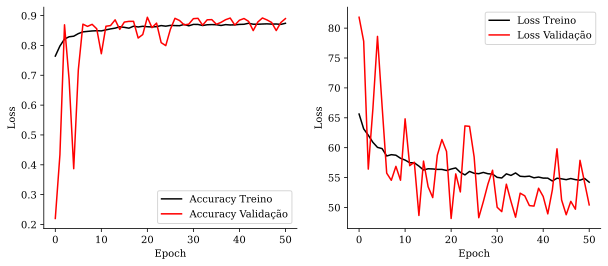

In [ ]:
# Apresentar evolução da loss e da accuracy ao longo do treino
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

plt.subplot(1, 2, 1)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.plot(history['accuracy'], label='Accuracy Treino', color='black')
plt.plot(history['val_accuracy'], label='Accuracy Validação', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.plot(history['loss'], label='Loss Treino', color='black')
plt.plot(history['val_loss'], label='Loss Validação', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

              precision    recall  f1-score   support

         Mel       1.00      0.01      0.02       115
          QS       0.69      0.94      0.79       378
         Nev       0.44      0.33      0.38        92

    accuracy                           0.66       585
   macro avg       0.71      0.42      0.40       585
weighted avg       0.71      0.66      0.58       585



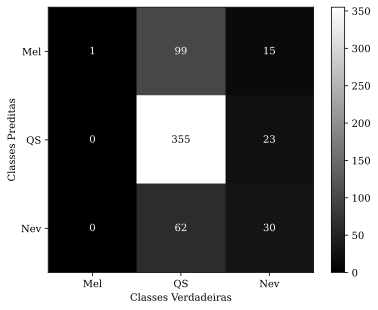

In [ ]:
# Definir labels
labels = ['Mel', 'QS', 'Nev']

# Carrregar o melhor modelo custom de classificação
model = tf.keras.models.load_model('/content/drive/MyDrive/MS Data Science/Deep Learning for Computer Vision/TrabalhoAPVC/data/tmp/best_class.keras')

# Avaliar o modelo no conjunto de teste
y_pred = []
y_true = []

for x, y in test_ds:
    y_pred.extend(np.argmax(model.predict(x, verbose = 0), axis=1))
    y_true.extend(np.argmax(y, axis=1))

y_pred = np.array(y_pred)
y_true = np.array(y_true)

# Calcular e apresentar o relatório de classificação
print(classification_report(y_true, y_pred, target_names=labels))

# Calcular e apresentar a matriz de confusáoo
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='gray')
plt.xlabel('Classes Verdadeiras')
plt.ylabel('Classes Preditas')
plt.show()

## 3.4 Com *Oversampling* usando *offline Data Augmentation*

In [ ]:
# Função de data augmentation
def augment_image(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.3)
    image = tf.image.random_contrast(image, lower=0.7, upper=1.3)
    image = tf.image.random_saturation(image, lower=0.7, upper=1.3)
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.1, dtype=tf.float32)
    image = tf.add(image, noise)

    return image

def augment_and_save_images(input_dir, output_dir, total_images):
    os.makedirs(output_dir, exist_ok=True)
    image_files = os.listdir(input_dir)
    num_original_images = len(image_files)
    num_augmented_images = total_images - num_original_images
    count = 0

    # Copy original images to the output directory
    for image_file in image_files:
        src_path = os.path.join(input_dir, image_file)
        dst_path = os.path.join(output_dir, image_file)
        os.makedirs(os.path.dirname(dst_path), exist_ok=True)
        if os.path.isfile(src_path):
            shutil.copy(src_path, dst_path)

    # Augment and save new images until total_images is reached
    while count < num_augmented_images:
        for image_file in image_files:
            if count >= num_augmented_images:
                break
            image_path = os.path.join(input_dir, image_file)
            image = load_img(image_path)
            image_array = img_to_array(image)
            augmented_image = augment_image(image_array)
            augmented_image_path = os.path.join(output_dir, f'aug_{count}_{image_file}')
            os.makedirs(os.path.dirname(augmented_image_path), exist_ok=True)
            save_img(augmented_image_path, augmented_image)
            count += 1

# Caminhos dos diretórios
mel_dir = '/content/drive/MyDrive/MS Data Science/Deep Learning for Computer Vision/TrabalhoAPVC/data/segmentation_outputs/Mel'
qs_dir = '/content/drive/MyDrive/MS Data Science/Deep Learning for Computer Vision/TrabalhoAPVC/data/segmentation_outputs/QS'
nev_dir = '/content/drive/MyDrive/MS Data Science/Deep Learning for Computer Vision/TrabalhoAPVC/data/segmentation_outputs/Nev'

augmented_mel_dir = '/content/drive/MyDrive/MS Data Science/Deep Learning for Computer Vision/TrabalhoAPVC/data/segmentation_outputs_aug/Mel'
augmented_qs_dir = '/content/drive/MyDrive/MS Data Science/Deep Learning for Computer Vision/TrabalhoAPVC/data/segmentation_outputs_aug/QS'
augmented_nev_dir = '/content/drive/MyDrive/MS Data Science/Deep Learning for Computer Vision/TrabalhoAPVC/data/segmentation_outputs_aug/Nev'

# Número de imagens aumentadas necessárias
num_augmented_images = len(os.listdir(nev_dir))

# Augmentar e salvar as imagens
augment_and_save_images(mel_dir, augmented_mel_dir, num_augmented_images)
augment_and_save_images(qs_dir, augmented_qs_dir, num_augmented_images)

# Copiar as imagens da classe maioritária para o novo diretório
os.makedirs(augmented_nev_dir, exist_ok=True)
for file_name in os.listdir(nev_dir):
    full_file_name = os.path.join(nev_dir, file_name)
    if os.path.isfile(full_file_name):
        dst_path = os.path.join(augmented_nev_dir, file_name)
        os.makedirs(os.path.dirname(dst_path), exist_ok=True)
        shutil.copy(full_file_name, dst_path)

Found 2750 files belonging to 3 classes.
Using 1925 files for training.
Found 2750 files belonging to 3 classes.
Using 825 files for validation.
Epoch 1/100
193/193 [==============================] - 20s 70ms/step - loss: 0.9853 - accuracy: 0.6369 - val_loss: 0.9181 - val_accuracy: 0.6917
Epoch 2/100
193/193 [==============================] - 12s 64ms/step - loss: 0.8812 - accuracy: 0.6655 - val_loss: 2.8129 - val_accuracy: 0.6917
Epoch 3/100
193/193 [==============================] - 13s 65ms/step - loss: 0.8389 - accuracy: 0.6649 - val_loss: 0.8521 - val_accuracy: 0.6917
Epoch 4/100
193/193 [==============================] - 12s 63ms/step - loss: 0.8243 - accuracy: 0.6660 - val_loss: 1.0595 - val_accuracy: 0.6583
Epoch 5/100
193/193 [==============================] - 12s 63ms/step - loss: 0.8581 - accuracy: 0.6639 - val_loss: 1.5618 - val_accuracy: 0.6917
Epoch 6/100
193/193 [==============================] - 12s 63ms/step - loss: 0.8006 - accuracy: 0.6717 - val_loss: 1.1808 - val_ac

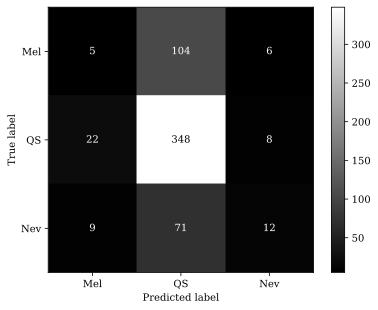

In [ ]:
# Definir callbacks

save_best = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/drive/MyDrive/MS Data Science/Deep Learning for Computer Vision/TrabalhoAPVC/data/tmp/best_class_custom_over.keras',
    monitor='val_loss',
    save_best_only=True
)

# Carregar as imagens já segmentadas
train_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/drive/MyDrive/MS Data Science/Deep Learning for Computer Vision/TrabalhoAPVC/data/segmentation_outputs",
    labels='inferred',
    label_mode='categorical',
    validation_split=0.3,
    subset='training',
    seed=123,
    image_size=(192, 256),
    batch_size=10
)

val_test_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/drive/MyDrive/MS Data Science/Deep Learning for Computer Vision/TrabalhoAPVC/data/segmentation_outputs",
    labels='inferred',
    label_mode='categorical',
    validation_split=0.3,
    subset='validation',
    seed=123,
    image_size=(192, 256),
    batch_size=10
)

# Separar o dataset de validação em validação e teste
val_size = int(0.3 * len(val_test_ds))
test_size = len(val_test_ds) - val_size

val_ds = val_test_ds.take(val_size)
test_ds = val_test_ds.skip(val_size)

# Normalizar as imagens
train_ds = train_ds.map(lambda x, y: (x / 255.0, y))
val_ds = val_ds.map(lambda x, y: (x / 255.0, y))
test_ds = test_ds.map(lambda x, y: (x / 255.0, y))

# Prefetch para melhorar a performance
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Criar e compilar o modelo
input_shape = (192, 256, 3)
num_classes = 3
model = create_class_model(input_shape, num_classes)
model.compile(optimizer=Adam(learning_rate=0.001), loss=CategoricalCrossentropy(), metrics=['accuracy'])
model.build((None, 192, 256, 3))

# Treinar o modelo
model.fit(train_ds, validation_data=val_ds, epochs=100, callbacks=[early_stopping, save_best])

# Definir labels
labels = ['Mel', 'QS', 'Nev']

# Carrregar o melhor modelo custom de classificação
model = tf.keras.models.load_model('/content/drive/MyDrive/MS Data Science/Deep Learning for Computer Vision/TrabalhoAPVC/data/tmp/best_class_over.keras', safe_mode=False)

# Avaliar o modelo no conjunto de teste
y_pred = []
y_true = []

for x, y in test_ds:
    y_pred.extend(np.argmax(model.predict(x, verbose = 0), axis=1))
    y_true.extend(np.argmax(y, axis=1))

y_pred = np.array(y_pred)
y_true = np.array(y_true)

# Calcular e apresentar o relatório de classificação
print(classification_report(y_true, y_pred, target_names=labels))

# Calcular e apresentar a matriz de confusáoo
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
plt.xlabel('Classes Verdadeiras')
plt.ylabel('Classes Preditas')
disp.plot(cmap='gray')
plt.show()

## 3.3 Com *Undersampling*

Found 2750 files belonging to 3 classes.
Using 1925 files for training.
Found 2750 files belonging to 3 classes.
Using 825 files for validation.
Class counts: [ 366. 1298.  261.]
Epoch 1/100
193/193 [==============================] - 20s 69ms/step - loss: 1.0280 - accuracy: 0.6197 - val_loss: 1.1792 - val_accuracy: 0.6917
Epoch 2/100
193/193 [==============================] - 13s 67ms/step - loss: 0.9420 - accuracy: 0.6488 - val_loss: 0.8590 - val_accuracy: 0.6917
Epoch 3/100
193/193 [==============================] - 13s 64ms/step - loss: 0.8687 - accuracy: 0.6545 - val_loss: 1.1351 - val_accuracy: 0.6917
Epoch 4/100
193/193 [==============================] - 12s 64ms/step - loss: 0.8610 - accuracy: 0.6613 - val_loss: 1.3346 - val_accuracy: 0.6917
Epoch 5/100
193/193 [==============================] - 12s 64ms/step - loss: 0.8169 - accuracy: 0.6691 - val_loss: 1.4386 - val_accuracy: 0.6917
Epoch 6/100
193/193 [==============================] - 12s 63ms/step - loss: 0.8104 - accuracy: 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


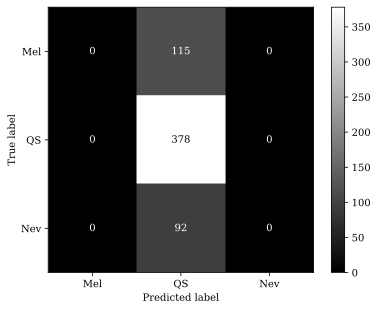

In [ ]:
# Definir callbacks
save_best = ModelCheckpoint(
    filepath='/content/drive/MyDrive/MS Data Science/Deep Learning for Computer Vision/TrabalhoAPVC/data/tmp/best_class_custom_under.keras',
    monitor='val_loss',
    save_best_only=True
)

# Carregar as imagens já segmentadas
train_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/drive/MyDrive/MS Data Science/Deep Learning for Computer Vision/TrabalhoAPVC/data/segmentation_outputs",
    labels='inferred',
    label_mode='categorical',
    validation_split=0.3,
    subset='training',
    seed=123,
    image_size=(192, 256),
    batch_size=10
)

val_test_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/drive/MyDrive/MS Data Science/Deep Learning for Computer Vision/TrabalhoAPVC/data/segmentation_outputs",
    labels='inferred',
    label_mode='categorical',
    validation_split=0.3,
    subset='validation',
    seed=123,
    image_size=(192, 256),
    batch_size=10
)

# Dividir o dataset de validação em validação e teste
val_size = int(0.3 * len(val_test_ds))
test_size = len(val_test_ds) - val_size

val_ds = val_test_ds.take(val_size)
test_ds = val_test_ds.skip(val_size)

# Converter datasets em listas para manipulação
train_images, train_labels = [], []
for images, labels in train_ds:
    train_images.extend(images.numpy())
    train_labels.extend(labels.numpy())

train_images = np.array(train_images)
train_labels = np.array(train_labels)

# Contar as instâncias de cada classe
class_counts = np.sum(train_labels, axis=0)
print("Class counts:", class_counts)

# Obter a contagem da classe 0 (Melanoma)
count_class_0 = int(class_counts[0])

# Diminuir aleatoriamente o número de imagens da classe 1 (Nevo) para um núnmero igual à classe 0 (Melanoma)
class_1_indices = np.where(train_labels[:, 1] == 1)[0]
undersample_indices = np.random.choice(class_1_indices, count_class_0, replace=False)

# Selecionar todas as imagens das outras classes
class_0_indices = np.where(train_labels[:, 0] == 1)[0]
class_2_indices = np.where(train_labels[:, 2] == 1)[0]

# Combinar os índices selecionados
final_indices = np.concatenate([class_0_indices, undersample_indices, class_2_indices])

# Criar o dataset de treino balanceado
train_images_balanced = train_images[final_indices]
train_labels_balanced = train_labels[final_indices]

# Criar o dataset de treino final
train_ds_balanced = tf.data.Dataset.from_tensor_slices((train_images_balanced, train_labels_balanced))

# Normalizar as imagens
train_ds_balanced = train_ds_balanced.map(lambda x, y: (x / 255.0, y))
val_ds = val_ds.map(lambda x, y: (x / 255.0, y))
test_ds = test_ds.map(lambda x, y: (x / 255.0, y))

# Prefetch para melhorar a performance
train_ds_balanced = train_ds_balanced.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Criar e compilar o modelo
input_shape = (192, 256, 3)
num_classes = 3
model = create_class_model(input_shape, num_classes)
model.compile(optimizer=Adam(learning_rate=0.001), loss=CategoricalCrossentropy(), metrics=['accuracy'])
model.build((None, 192, 256, 3))

# Treinar o modelo
model.fit(train_ds, validation_data=val_ds, epochs=100, callbacks=[early_stopping, save_best])

# Definir labels
labels = ['Mel', 'QS', 'Nev']

# Carrregar o melhor modelo custom de classificação
model = tf.keras.models.load_model('/content/drive/MyDrive/MS Data Science/Deep Learning for Computer Vision/TrabalhoAPVC/data/tmp/best_class_custom_under.keras', safe_mode=False)

# Avaliar o modelo no conjunto de teste
y_pred = []
y_true = []

for x, y in test_ds:
    y_pred.extend(np.argmax(model.predict(x, verbose = 0), axis=1))
    y_true.extend(np.argmax(y, axis=1))

y_pred = np.array(y_pred)
y_true = np.array(y_true)

# Calcular e apresentar o relatório de classificação
print(classification_report(y_true, y_pred, target_names=labels))

# Calcular e apresentar a matriz de confusáoo
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
plt.xlabel('Classes Verdadeiras')
plt.ylabel('Classes Preditas')
disp.plot(cmap='gray')
plt.show()

## 3.2 Com *Class Weighting*

Found 2750 files belonging to 3 classes.
Using 1925 files for training.
Found 2750 files belonging to 3 classes.
Using 825 files for validation.
Epoch 1/100
193/193 [==============================] - 20s 70ms/step - loss: 3.7309 - accuracy: 0.3662 - val_loss: 1.9682 - val_accuracy: 0.2708
Epoch 2/100
193/193 [==============================] - 13s 66ms/step - loss: 3.5538 - accuracy: 0.3668 - val_loss: 1.6601 - val_accuracy: 0.5083
Epoch 3/100
193/193 [==============================] - 12s 63ms/step - loss: 3.3362 - accuracy: 0.3787 - val_loss: 2.2990 - val_accuracy: 0.1792
Epoch 4/100
193/193 [==============================] - 13s 65ms/step - loss: 3.2517 - accuracy: 0.3626 - val_loss: 1.0814 - val_accuracy: 0.3292
Epoch 5/100
193/193 [==============================] - 12s 63ms/step - loss: 3.2127 - accuracy: 0.3657 - val_loss: 1.1719 - val_accuracy: 0.2292
Epoch 6/100
193/193 [==============================] - 13s 65ms/step - loss: 3.2362 - accuracy: 0.3673 - val_loss: 1.0007 - val_ac

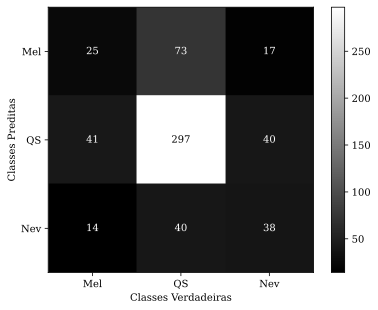

In [ ]:
# Definir callbacks
save_best = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/drive/MyDrive/MS Data Science/Deep Learning for Computer Vision/TrabalhoAPVC/data/tmp/best_class_custom_weighting.keras',
    monitor='val_loss',
    save_best_only=True
)


# Carregar as imagens já segmentadas
train_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/drive/MyDrive/MS Data Science/Deep Learning for Computer Vision/TrabalhoAPVC/data/segmentation_outputs",
    labels='inferred',
    label_mode='categorical',
    validation_split=0.3,
    subset='training',
    seed=123,
    image_size=(192, 256),
    batch_size=10
)

val_test_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/drive/MyDrive/MS Data Science/Deep Learning for Computer Vision/TrabalhoAPVC/data/segmentation_outputs",
    labels='inferred',
    label_mode='categorical',
    validation_split=0.3,
    subset='validation',
    seed=123,
    image_size=(192, 256),
    batch_size=10
)

# Separar o dataset de validação em validação e teste
val_size = int(0.3 * len(val_test_ds))
test_size = len(val_test_ds) - val_size

val_ds = val_test_ds.take(val_size)
test_ds = val_test_ds.skip(val_size)

# Normalizar as imagens
train_ds = train_ds.map(lambda x, y: (x / 255.0, y))
val_ds = val_ds.map(lambda x, y: (x / 255.0, y))
test_ds = test_ds.map(lambda x, y: (x / 255.0, y))

# Prefetch para melhorar a performance
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Criar e compilar o modelo
input_shape = (192, 256, 3)
num_classes = 3
model = create_class_model(input_shape, num_classes)
model.compile(optimizer=Adam(learning_rate=0.001), loss=CategoricalCrossentropy(), metrics=['accuracy'])
model.build((None, 192, 256, 3))

# Definir pesos das classes com base no inverso da frequência
total_samples = 521 + 1843 + 386
class_weight = {
    0: total_samples / 521,   # Melanoma
    1: total_samples / 1843,  # Nevo
    2: total_samples / 386    # Queratose
}

# Treinar o modelo
model.fit(train_ds, validation_data=val_ds, epochs=100, callbacks=[early_stopping, save_best], class_weight=class_weight)

# Definir labels
labels = ['Mel', 'QS', 'Nev']

# Carrregar o melhor modelo custom de classificação
model = tf.keras.models.load_model('/content/drive/MyDrive/MS Data Science/Deep Learning for Computer Vision/TrabalhoAPVC/data/tmp/best_class_custom_weighting.keras', safe_mode=False)

# Avaliar o modelo no conjunto de teste
y_pred = []
y_true = []

for x, y in test_ds:
    y_pred.extend(np.argmax(model.predict(x, verbose=0), axis=1))
    y_true.extend(np.argmax(y, axis=1))

y_pred = np.array(y_pred)
y_true = np.array(y_true)

# Calcular e apresentar o relatório de classificação
print(classification_report(y_true, y_pred, target_names=labels))

# Calcular e apresentar a matriz de confusáoo
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='gray')
plt.xlabel('Classes Verdadeiras')
plt.ylabel('Classes Preditas')
plt.show()

## 3.5 Com as imagens originais não segmentadas + *Undersampling*:

Found 2750 files belonging to 3 classes.
Using 1925 files for training.
Found 2750 files belonging to 3 classes.
Using 825 files for validation.
Class counts: [ 366. 1298.  261.]
Epoch 1/100
193/193 [==============================] - 83s 381ms/step - loss: 1.3292 - accuracy: 0.5673 - val_loss: 18.6911 - val_accuracy: 0.6917
Epoch 2/100
193/193 [==============================] - 65s 321ms/step - loss: 1.1160 - accuracy: 0.6083 - val_loss: 5.4176 - val_accuracy: 0.6917
Epoch 3/100
193/193 [==============================] - 64s 317ms/step - loss: 0.9480 - accuracy: 0.6338 - val_loss: 4.3713 - val_accuracy: 0.6917
Epoch 4/100
193/193 [==============================] - 65s 319ms/step - loss: 0.8656 - accuracy: 0.6613 - val_loss: 1.9946 - val_accuracy: 0.6917
Epoch 5/100
193/193 [==============================] - 65s 321ms/step - loss: 0.8502 - accuracy: 0.6670 - val_loss: 2.8949 - val_accuracy: 0.1792
Epoch 6/100
193/193 [==============================] - 64s 317ms/step - loss: 0.8415 - acc

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


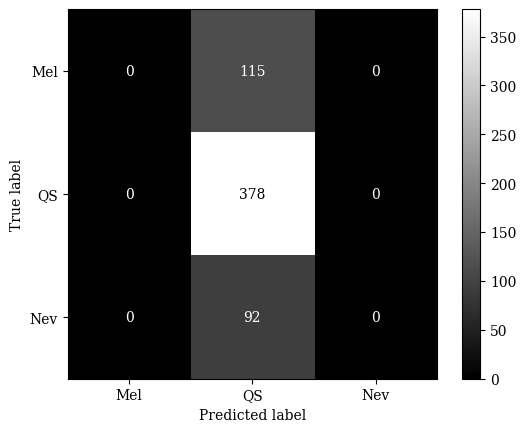

In [ ]:
# Definir callbacks
save_best = ModelCheckpoint(
    filepath='/content/drive/MyDrive/MS Data Science/Deep Learning for Computer Vision/TrabalhoAPVC/data/tmp/best_class_custom_non_seg_under.keras',
    monitor='val_loss',
    save_best_only=True
)

# Carregar as imagens já segmentadas
train_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/drive/MyDrive/MS Data Science/Deep Learning for Computer Vision/TrabalhoAPVC/data/outputs_originals",
    labels='inferred',
    label_mode='categorical',
    validation_split=0.3,
    subset='training',
    seed=123,
    image_size=(192, 256),
    batch_size=10
)

val_test_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/drive/MyDrive/MS Data Science/Deep Learning for Computer Vision/TrabalhoAPVC/data/outputs_originals",
    labels='inferred',
    label_mode='categorical',
    validation_split=0.3,
    subset='validation',
    seed=123,
    image_size=(192, 256),
    batch_size=10
)

# Dividir o dataset de validação em validação e teste
val_size = int(0.3 * len(val_test_ds))
test_size = len(val_test_ds) - val_size

val_ds = val_test_ds.take(val_size)
test_ds = val_test_ds.skip(val_size)

# Converter datasets em listas para manipulação
train_images, train_labels = [], []
for images, labels in train_ds:
    train_images.extend(images.numpy())
    train_labels.extend(labels.numpy())

train_images = np.array(train_images)
train_labels = np.array(train_labels)

# Contar as instâncias de cada classe
class_counts = np.sum(train_labels, axis=0)
print("Class counts:", class_counts)

# Obter a contagem da classe 0 (Melanoma)
count_class_0 = int(class_counts[0])

# Diminuir aleatoriamente o número de imagens da classe 1 (Nevo) para um núnmero igual à classe 0 (Melanoma)
class_1_indices = np.where(train_labels[:, 1] == 1)[0]
undersample_indices = np.random.choice(class_1_indices, count_class_0, replace=False)

# Selecionar todas as imagens das outras classes
class_0_indices = np.where(train_labels[:, 0] == 1)[0]
class_2_indices = np.where(train_labels[:, 2] == 1)[0]

# Combinar os índices selecionados
final_indices = np.concatenate([class_0_indices, undersample_indices, class_2_indices])

# Criar o dataset de treino balanceado
train_images_balanced = train_images[final_indices]
train_labels_balanced = train_labels[final_indices]

# Criar o dataset de treino final
train_ds_balanced = tf.data.Dataset.from_tensor_slices((train_images_balanced, train_labels_balanced))

# Normalizar as imagens
train_ds_balanced = train_ds_balanced.map(lambda x, y: (x / 255.0, y))
val_ds = val_ds.map(lambda x, y: (x / 255.0, y))
test_ds = test_ds.map(lambda x, y: (x / 255.0, y))

# Prefetch para melhorar a performance
train_ds_balanced = train_ds_balanced.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Criar e compilar o modelo
input_shape = (192, 256, 3)
num_classes = 3
model = create_class_model(input_shape, num_classes)
model.compile(optimizer=Adam(learning_rate=0.001), loss=CategoricalCrossentropy(), metrics=['accuracy'])
model.build((None, 192, 256, 3))

# Treinar o modelo
model.fit(train_ds, validation_data=val_ds, epochs=100, callbacks=[early_stopping, save_best])

# Definir labels
labels = ['Mel', 'QS', 'Nev']

# Carrregar o melhor modelo custom de classificação
model = tf.keras.models.load_model('/content/drive/MyDrive/MS Data Science/Deep Learning for Computer Vision/TrabalhoAPVC/data/tmp/best_class_custom_non_seg_under.keras', safe_mode=False)

# Avaliar o modelo no conjunto de teste
y_pred = []
y_true = []

for x, y in test_ds:
    y_pred.extend(np.argmax(model.predict(x, verbose = 0), axis=1))
    y_true.extend(np.argmax(y, axis=1))

y_pred = np.array(y_pred)
y_true = np.array(y_true)

# Calcular e apresentar o relatório de classificação
print(classification_report(y_true, y_pred, target_names=labels))

# Calcular e apresentar a matriz de confusáoo
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='gray')
plt.xlabel('Classes Verdadeiras')
plt.ylabel('Classes Preditas')
plt.show()

# **4. Classificação com transferência de conhecimento**

## 4.1 Base

In [ ]:
# Definir callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

save_best = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/drive/MyDrive/MS Data Science/Deep Learning for Computer Vision/TrabalhoAPVC/data/tmp/best_class_mobilenet.keras',
    monitor='val_loss',
    save_best_only=True
)

# Carregar as imagens já segmentadas
train_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/drive/MyDrive/MS Data Science/Deep Learning for Computer Vision/TrabalhoAPVC/data/segmentation_outputs",
    labels='inferred',
    label_mode='categorical',
    validation_split=0.3,
    subset='training',
    seed=123,
    image_size=(192, 256),
    batch_size=10
)

val_test_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/drive/MyDrive/MS Data Science/Deep Learning for Computer Vision/TrabalhoAPVC/data/segmentation_outputs",
    labels='inferred',
    label_mode='categorical',
    validation_split=0.3,
    subset='validation',
    seed=123,
    image_size=(192, 256),
    batch_size=10
)

labels = ['Mel', 'Nev', 'QS']

# Dividir o dataset de validação em validação e teste
val_size = int(0.3 * len(val_test_ds))
test_size = len(val_test_ds) - val_size

val_ds = val_test_ds.take(val_size)
test_ds = val_test_ds.skip(val_size)

# Normalizar as imagens
train_ds = train_ds.map(lambda x, y: (x / 255.0, y))
val_ds = val_ds.map(lambda x, y: (x / 255.0, y))
test_ds = test_ds.map(lambda x, y: (x / 255.0, y))

# Prefetch para melhorar a performance
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Found 2750 files belonging to 3 classes.
Using 1925 files for training.
Found 2750 files belonging to 3 classes.
Using 825 files for validation.


In [ ]:
# Criar o modelo MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(192, 256, 3))

# Congelar as camadas do modelo base
base_model.trainable = False

# Adicionar camadas de topo para classificação
model = Sequential([
    Input(shape=(192, 256, 3)),
    Lambda(preprocess_input),
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # Assuming 3 classes
])

# Criar e compilar o modelo
model.compile(optimizer=Adam(learning_rate=0.001), loss=CategoricalCrossentropy(), metrics=['accuracy'])
model.build((None, 192, 256, 3))

# Sumário do modelo
model.summary()

# Treinar o modelo
history = model.fit(train_ds, validation_data=val_ds, epochs=100, callbacks=[early_stopping, save_best])

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_18 (Lambda)          (None, 192, 256, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 6, 8, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_3  (None, 1280)              0         
 1 (GlobalAveragePooling2D)                                      
                                                                 
 dense_62 (Dense)            (None, 128)               163968    
                                                                 
 dropout_35 (Dropout)        (None, 128)               0         
                                                                 
 dense_63 (Dense)            (None, 3)               

              precision    recall  f1-score   support

         Mel       0.00      0.00      0.00       115
         Nev       0.65      1.00      0.79       378
          QS       0.00      0.00      0.00        92

    accuracy                           0.65       585
   macro avg       0.22      0.33      0.26       585
weighted avg       0.42      0.65      0.51       585



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


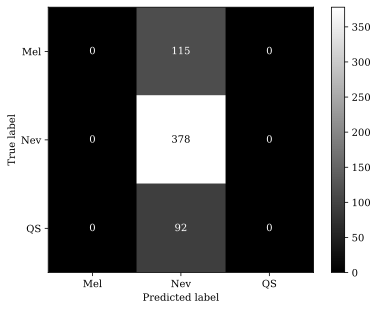

In [ ]:
# Carregar o melhor modelo
model = tf.keras.models.load_model('/content/drive/MyDrive/MS Data Science/Deep Learning for Computer Vision/TrabalhoAPVC/data/tmp/best_class_mobilenet.keras', safe_mode=False)

# avaliar o modelo no conjunto de teste
y_pred = []
y_true = []

for x, y in test_ds:
    y_pred.extend(np.argmax(model.predict(x, verbose = 0), axis=1))
    y_true.extend(np.argmax(y, axis=1))

y_pred = np.array(y_pred)
y_true = np.array(y_true)

# Calcular e apresentar o relatório de classificação
print(classification_report(y_true, y_pred, target_names=labels))

# Calcular e apresentar matriz de confusão
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='gray')
plt.show()

## 4.2 Com *Class Weighting*

In [ ]:
# Definir callback
save_best = ModelCheckpoint(
    filepath='/content/drive/MyDrive/MS Data Science/Deep Learning for Computer Vision/TrabalhoAPVC/data/tmp/best_class_mobilenet_class_weighting.keras',
    monitor='val_loss',
    save_best_only=True
)

# Criar o modelo MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(192, 256, 3))

# Congelar as camadas do modelo base
base_model.trainable = False

# Adicionar camadas de topo para classificação
model = Sequential([
    Input(shape=(192, 256, 3)),
    Lambda(preprocess_input),
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # Assuming 3 classes
])

# Criar e compilar o modelo
model.compile(optimizer=Adam(learning_rate=0.001), loss=CategoricalCrossentropy(), metrics=['accuracy'])
model.build((None, 192, 256, 3))


# Definir pesos das classes com base no inverso da frequência
total_samples = 521 + 1843 + 386
class_weight = {
    0: total_samples / 521,   # Melanoma
    1: total_samples / 1843,  # Nevo
    2: total_samples / 386    # Queratose
}

# Treinar o modelo
history = model.fit(train_ds, validation_data=val_ds, epochs=100, callbacks=[early_stopping, save_best], class_weight=class_weight)

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_14 (Lambda)          (None, 192, 256, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 6, 8, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
 5 (GlobalAveragePooling2D)                                      
                                                                 
 dense_30 (Dense)            (None, 128)               163968    
                                                                 
 dropout_15 (Dropout)        (None, 128)               0         
                                                                 
 dense_31 (Dense)            (None, 3)               

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         Mel       0.00      0.00      0.00       115
         Nev       0.65      1.00      0.79       378
          QS       0.00      0.00      0.00        92

    accuracy                           0.65       585
   macro avg       0.22      0.33      0.26       585
weighted avg       0.42      0.65      0.51       585



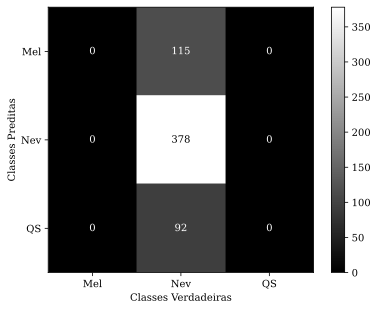

In [ ]:
# Carregar o melhor modelo
model = tf.keras.models.load_model('/content/drive/MyDrive/MS Data Science/Deep Learning for Computer Vision/TrabalhoAPVC/data/tmp/best_class_mobilenet_class_weighting.keras', safe_mode=False)

# avaliar o modelo no conjunto de teste
y_pred = []
y_true = []

for x, y in test_ds:
    y_pred.extend(np.argmax(model.predict(x, verbose = 0), axis=1))
    y_true.extend(np.argmax(y, axis=1))

y_pred = np.array(y_pred)
y_true = np.array(y_true)

# Calcular e apresentar o relatório de classificação
print(classification_report(y_true, y_pred, target_names=labels))

# Calcular e apresentar matriz de confusão
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='gray')
plt.xlabel('Classes Verdadeiras')
plt.ylabel('Classes Preditas')
plt.show()

## 4.3 Com *Undersampling*



In [ ]:
# Definir callbacks
save_best = ModelCheckpoint(
    filepath='/content/drive/MyDrive/MS Data Science/Deep Learning for Computer Vision/TrabalhoAPVC/data/tmp/best_class_mobilenet_under.keras',
    monitor='val_loss',
    save_best_only=True
)

# Carregar as imagens já segmentadas
train_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/drive/MyDrive/MS Data Science/Deep Learning for Computer Vision/TrabalhoAPVC/data/segmentation_outputs",
    labels='inferred',
    label_mode='categorical',
    validation_split=0.3,
    subset='training',
    seed=123,
    image_size=(192, 256),
    batch_size=10
)

val_test_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/drive/MyDrive/MS Data Science/Deep Learning for Computer Vision/TrabalhoAPVC/data/segmentation_outputs",
    labels='inferred',
    label_mode='categorical',
    validation_split=0.3,
    subset='validation',
    seed=123,
    image_size=(192, 256),
    batch_size=10
)

# Dividir o dataset de validação em validação e teste
val_size = int(0.3 * len(val_test_ds))
test_size = len(val_test_ds) - val_size

val_ds = val_test_ds.take(val_size)
test_ds = val_test_ds.skip(val_size)

# Converter datasets em listas para manipulação
train_images, train_labels = [], []
for images, labels in train_ds:
    train_images.extend(images.numpy())
    train_labels.extend(labels.numpy())

train_images = np.array(train_images)
train_labels = np.array(train_labels)

# Contar as instâncias de cada classe
class_counts = np.sum(train_labels, axis=0)
print("Class counts:", class_counts)

# Obter a contagem da classe 0 (Melanoma)
count_class_0 = int(class_counts[0])

# Selecionar aleatoriamente imagens da classe 1 (Nevo) para um núnmero igual à classe 0 (Melanoma)
class_1_indices = np.where(train_labels[:, 1] == 1)[0]
undersample_indices = np.random.choice(class_1_indices, count_class_0, replace=False)

# Selecionar todas as imagens das outras classes
class_0_indices = np.where(train_labels[:, 0] == 1)[0]
class_2_indices = np.where(train_labels[:, 2] == 1)[0]

# Combinar os índices selecionados
final_indices = np.concatenate([class_0_indices, undersample_indices, class_2_indices])

# Criar o dataset de treino balanceado
train_images_balanced = train_images[final_indices]
train_labels_balanced = train_labels[final_indices]

# Criar o dataset de treino final
train_ds_balanced = tf.data.Dataset.from_tensor_slices((train_images_balanced, train_labels_balanced))

# Normalizar as imagens
train_ds_balanced = train_ds_balanced.map(lambda x, y: (x / 255.0, y))
val_ds = val_ds.map(lambda x, y: (x / 255.0, y))
test_ds = test_ds.map(lambda x, y: (x / 255.0, y))

# Prefetch para melhorar a performance
train_ds_balanced = train_ds_balanced.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Criar o modelo MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(192, 256, 3))
base_model.trainable = False

model = Sequential([
    Input(shape=(192, 256, 3)),
    Lambda(tf.keras.applications.mobilenet.preprocess_input),
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

# Compilar o modelo
model.compile(optimizer=Adam(learning_rate=0.001), loss=CategoricalCrossentropy(), metrics=['accuracy'])
model.build((None, 192, 256, 3))

# Treinar o modelo
history = model.fit(train_ds, validation_data=val_ds, epochs=100, callbacks=[early_stopping, save_best])

# Definir callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

save_best = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/drive/MyDrive/MS Data Science/Deep Learning for Computer Vision/TrabalhoAPVC/data/tmp/best_class_mobilenet.keras',
    monitor='val_loss',
    save_best_only=True
)

# Carregar as imagens já segmentadas
train_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/drive/MyDrive/MS Data Science/Deep Learning for Computer Vision/TrabalhoAPVC/data/segmentation_outputs",
    labels='inferred',
    label_mode='categorical',
    validation_split=0.3,
    subset='training',
    seed=123,
    image_size=(192, 256),
    batch_size=10
)

val_test_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/drive/MyDrive/MS Data Science/Deep Learning for Computer Vision/TrabalhoAPVC/data/segmentation_outputs",
    labels='inferred',
    label_mode='categorical',
    validation_split=0.3,
    subset='validation',
    seed=123,
    image_size=(192, 256),
    batch_size=10
)

labels = ['Mel', 'Nev', 'QS']

# Dividir o dataset de validação em validação e teste
val_size = int(0.3 * len(val_test_ds))
test_size = len(val_test_ds) - val_size

val_ds = val_test_ds.take(val_size)
test_ds = val_test_ds.skip(val_size)

# Normalizar as imagens
train_ds = train_ds.map(lambda x, y: (x / 255.0, y))
val_ds = val_ds.map(lambda x, y: (x / 255.0, y))
test_ds = test_ds.map(lambda x, y: (x / 255.0, y))

# Prefetch para melhorar a performance
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Carregar o melhor modelo
model = tf.keras.models.load_model('/content/drive/MyDrive/MS Data Science/Deep Learning for Computer Vision/TrabalhoAPVC/data/tmp/best_class_mobilenet_under.keras', safe_mode=False)

# avaliar o modelo no conjunto de teste
y_pred = []
y_true = []

for x, y in test_ds:
    y_pred.extend(np.argmax(model.predict(x, verbose = 0), axis=1))
    y_true.extend(np.argmax(y, axis=1))

y_pred = np.array(y_pred)
y_true = np.array(y_true)

labels = ['Mel', 'Nev', 'QS']

# Calcular e apresentar o relatório de classificação
print(classification_report(y_true, y_pred, target_names=labels))

# Calcular e apresentar matriz de confusão
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='gray')
plt.xlabel('Classes Verdadeiras')
plt.ylabel('Classes Preditas')
plt.show()

Found 2750 files belonging to 3 classes.
Using 1925 files for training.
Found 2750 files belonging to 3 classes.
Using 825 files for validation.
Class counts: [ 366. 1298.  261.]


Epoch 1/100
193/193 [==============================] - 9s 29ms/step - loss: 0.8435 - accuracy: 0.6577 - val_loss: 0.8354 - val_accuracy: 0.6917
Epoch 2/100
193/193 [==============================] - 4s 18ms/step - loss: 0.7504 - accuracy: 0.6816 - val_loss: 0.8745 - val_accuracy: 0.6917
Epoch 3/100
193/193 [==============================] - 4s 18ms/step - loss: 0.7080 - accuracy: 0.7075 - val_loss: 0.9226 - val_accuracy: 0.6917
Epoch 4/100
193/193 [==============================] - 4s 18ms/step - loss: 0.6800 - accuracy: 0.7065 - val_loss: 0.9390 - val_accuracy: 0.6917
Epoch 5/100
193/193 [==============================] - 4s 18ms/step - loss: 0.6656 - accuracy: 0.7257 - val_loss: 1.0120 - val_accuracy: 0.6917
Epoch 6/100
193/193 [==============================] - 4s 18ms/step - loss: 0.6591 - accuracy: 0.7200 - val_loss: 1.1460 - val_accuracy: 0.6917
Epoch 7/100
193/193 [==============================] - 4s 19ms/step - loss: 0.6276 - accuracy: 0.7304 - val_loss: 1.1856 - val_accuracy:

## 4.4 Com *Oversampling* usando *offline Data Augmentation*


In [ ]:
# Definir callbacks
save_best = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/drive/MyDrive/MS Data Science/Deep Learning for Computer Vision/TrabalhoAPVC/data/tmp/best_class_mobilenet_over.keras',
    monitor='val_loss',
    save_best_only=True
)

# Carregar as imagens já segmentadas e com oversampling offline
train_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/drive/MyDrive/MS Data Science/Deep Learning for Computer Vision/TrabalhoAPVC/data/segmentation_outputs_aug",
    labels='inferred',
    label_mode='categorical',
    validation_split=0.3,
    subset='training',
    seed=123,
    image_size=(192, 256),
    batch_size=10
)

val_test_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/drive/MyDrive/MS Data Science/Deep Learning for Computer Vision/TrabalhoAPVC/data/segmentation_outputs",
    labels='inferred',
    label_mode='categorical',
    validation_split=0.3,
    subset='validation',
    seed=123,
    image_size=(192, 256),
    batch_size=10
)

labels = ['Mel', 'Nev', 'QS']

# Dividir o dataset de validação em validação e teste
val_size = int(0.3 * len(val_test_ds))
test_size = len(val_test_ds) - val_size

val_ds = val_test_ds.take(val_size)
test_ds = val_test_ds.skip(val_size)

# Normalizar as imagens
train_ds = train_ds.map(lambda x, y: (x / 255.0, y))
val_ds = val_ds.map(lambda x, y: (x / 255.0, y))
test_ds = test_ds.map(lambda x, y: (x / 255.0, y))

# Prefetch para melhorar a performance
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Criar o modelo MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(192, 256, 3))

# Congelar as camadas do modelo base
base_model.trainable = False

# Adicionar camadas de topo para classificação
model = Sequential([
    Input(shape=(192, 256, 3)),
    Lambda(preprocess_input),
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # Assuming 3 classes
])

# Criar e compilar o modelo
model.compile(optimizer=Adam(learning_rate=0.001), loss=CategoricalCrossentropy(), metrics=['accuracy'])
model.build((None, 192, 256, 3))

# Treinar o modelo
history = model.fit(train_ds, validation_data=val_ds, epochs=100, callbacks=[early_stopping, save_best])

# Definir labels
labels = ['Mel', 'QS', 'Nev']

# Carrregar o melhor modelo custom de classificação
model = tf.keras.models.load_model('/content/drive/MyDrive/MS Data Science/Deep Learning for Computer Vision/TrabalhoAPVC/data/tmp/best_class_mobilenet_over.keras', safe_mode=False)

# Avaliar o modelo no conjunto de teste
y_pred = []
y_true = []

for x, y in test_ds:
    y_pred.extend(np.argmax(model.predict(x, verbose = 0), axis=1))
    y_true.extend(np.argmax(y, axis=1))

y_pred = np.array(y_pred)
y_true = np.array(y_true)

# Calcular e apresentar o relatório de classificação
print(classification_report(y_true, y_pred, target_names=labels))

# Calcular e apresentar a matriz de confusáoo
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='gray')
plt.xlabel('Classes Verdadeiras')
plt.ylabel('Classes Preditas')
plt.show()

Found 5529 files belonging to 3 classes.
Using 3871 files for training.
Found 2750 files belonging to 3 classes.
Using 825 files for validation.
